## Imports

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
import math
import joblib


In [77]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/l2p_dance_model_Fs2_O.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/l2a_dance_model_Fs2_O.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/l2d_dance_model_Fs2_O.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/Fs2_B_O_S_DANCE_WALK_KIN_0.5sec.pkl') 

## Load Data

In [99]:
dataset = pd.read_csv('datasets/Fs3_B_O_DANCE_WALK_KIN_0.5sec.csv')
dataset.head()

max_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
0           0.684605                 0.268051                 0.236534   
1           0.438911                 0.265254                 0.229588   
2           0.440199                 0.266441                 0.223630   
3           0.500120                 0.386881                 0.393727   
4           0.562528                 0.447009                 0.596923   

   max_stride_length  avg_l_hand_chest_distance  avg_r_hand_chest_distance  \
0           0.478955                   0.469381                   0.455152   
1           0.283025                   0.468163                   0.452005   
2           0.309053                   0.455287                   0.439872   
3           0.452718                   0.418828                   0.440395   
4           0.488571                   0.361697                   0.522971   

   avg_l_elbow_hip_distance  avg_r_elbow_hip_distance  \
0                  0.351238                  0.336392   
1                  0.350459                  0.333469   
2                  0.343657                  0.325378   
3                  0.324313                  0.340373   
4                  0.286162                  0.430045   

   avg_neck_chest_distance  avg_neck_rotation_w  ...  r_foot_speed  \
0                 0.278741             0.011497  ...      0.531111   
1                 0.278750             0.011885  ...      0.014436   
2                 0.278739             0.017740  ...      0.072819   
3                 0.278729             0.033718  ...      0.464108   
4                 0.278747             0.041425  ...      0.139125   

   neck_speed  l_hand_acceleration_magnitude  r_hand_acceleration_magnitude  \
0    0.677884                       1.109843                       0.766334   
1    0.021416                       1.085836                       0.779991   
2    0.191442                       1.231576                       1.117785   
3    0.605356                       1.068333                       1.038694   
4    0.207208                       1.304347                       1.077684   

   l_foot_acceleration_magnitude  r_foot_acceleration_magnitude  \
0                       1.537713                       1.062221   
1                       1.575538                       1.049393   
2                       0.133194                       0.126177   
3                       1.638293                       1.021144   
4                       1.563165                       0.917321   

   neck_acceleration_magnitude  EMOTION_P  EMOTION_A  EMOTION_D  
0                     1.355767       -0.5        0.6        0.9  
1                     1.367237       -0.5        0.6        0.9  
2                     0.355767       -0.5        0.6        0.9  
3                     1.332992       -0.5        0.6        0.9  
4                     0.803440       -0.5        0.6        0.9  

[5 rows x 29 columns]

### Get only a few samples

In [100]:
test_dataset = dataset.sample(frac=0.1, random_state=42)

print("No Test Samples:",test_dataset.shape[0])

test_dataset = shuffle(test_dataset)

No Test Samples: 2637


### Split Features from Targets

In [101]:
test_y_sets = []
# List of np.arrays each containing the LMA features of a given column (i.e one list per feature)

In [102]:
test_X = pd.concat([test_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_X_OG = test_X.copy()

In [103]:
test_X_p = model_p.predict(test_dataset)
test_X_a = model_a.predict(test_dataset)
test_X_d = model_d.predict(test_dataset)

rows = []
for i in range(len(test_dataset)):
    rows.append([test_X_p[i], test_X_a[i], test_X_d[i]])

test_X = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_X.head()

EMOTION_P  EMOTION_A  EMOTION_D
0   0.146851   0.546275   0.187875
1   0.298866   0.397858   0.255466
2   0.293444   0.404485   0.267051
3   0.121995   0.306490   0.146468
4   0.031451   0.612431   0.310164

In [104]:
for colname in test_dataset.columns:
    test_y_sets.append(pd.concat([test_dataset.pop(x) for x in [colname]], axis=1))

In [105]:
test_X.head()

EMOTION_P  EMOTION_A  EMOTION_D
0   0.146851   0.546275   0.187875
1   0.298866   0.397858   0.255466
2   0.293444   0.404485   0.267051
3   0.121995   0.306490   0.146468
4   0.031451   0.612431   0.310164

In [106]:
print(len(test_y_sets))
print()

for i in range(len(test_y_sets)):
    print(test_y_sets[i].columns[0])

26

max_hand_distance
avg_l_hand_hip_distance
avg_r_hand_hip_distance
max_stride_length
avg_l_hand_chest_distance
avg_r_hand_chest_distance
avg_l_elbow_hip_distance
avg_r_elbow_hip_distance
avg_neck_chest_distance
avg_neck_rotation_w
avg_neck_rotation_x
avg_neck_rotation_y
avg_neck_rotation_z
avg_total_body_volume
avg_triangle_area_hands_neck
avg_triangle_area_feet_hips
l_hand_speed
r_hand_speed
l_foot_speed
r_foot_speed
neck_speed
l_hand_acceleration_magnitude
r_hand_acceleration_magnitude
l_foot_acceleration_magnitude
r_foot_acceleration_magnitude
neck_acceleration_magnitude


## Graphs showcasing the variation of LMA feature values (y) in regards to each emotional coordinate (x)

In [107]:
print(test_y_sets[8])

       avg_neck_chest_distance
14323                 0.274959
5456                  0.278859
22397                 0.277518
12233                 0.278810
210                   0.278293
...                        ...
13317                 0.278686
7293                  0.278511
13826                 0.278600
18559                 0.276116
6027                  0.278819

[2637 rows x 1 columns]


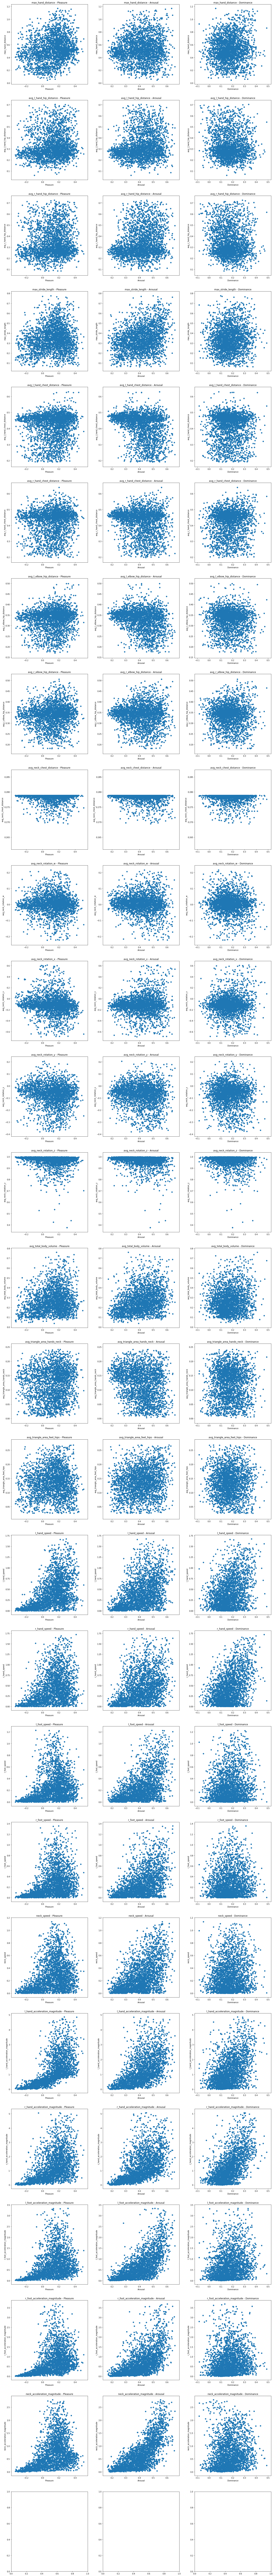

In [108]:
rows = 27
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(cols * 8, rows * 9))

for n in range(len(test_y_sets)):
    axs[n, 0].set_title(str(test_y_sets[n].columns[0]) + " - " + "Pleasure") 
    axs[n, 0].scatter(test_X.iloc[:, 0], test_y_sets[n])
    
    axs[n, 1].set_title(str(test_y_sets[n].columns[0]) + " - " + "Arousal") 
    axs[n, 1].scatter(test_X.iloc[:, 1], test_y_sets[n])
    
    axs[n, 2].set_title(str(test_y_sets[n].columns[0]) + " - " + "Dominance") 
    axs[n, 2].scatter(test_X.iloc[:, 2], test_y_sets[n])
    
    axs[n, 0].set_xlabel('Pleasure')
    axs[n, 0].set_ylabel(test_y_sets[n].columns[0])
    
    axs[n, 1].set_xlabel('Arousal')
    axs[n, 1].set_ylabel(test_y_sets[n].columns[0])
    
    axs[n, 2].set_xlabel('Dominance')
    axs[n, 2].set_ylabel(test_y_sets[n].columns[0])

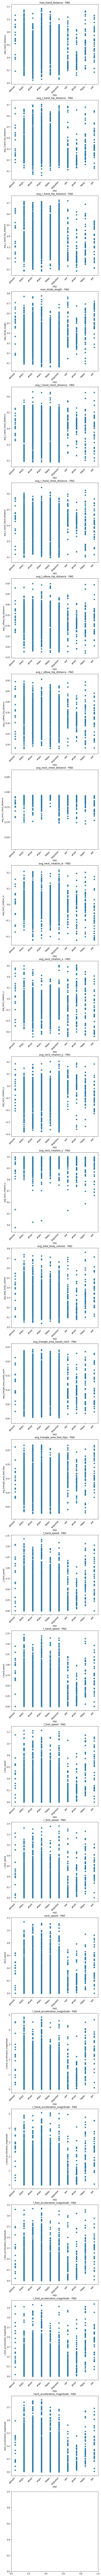

In [109]:
conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted" ,
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (0.0, 0.0, 0.0): "neutral",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

pad_indices = []
for index, row in test_X_OG.iterrows():
    row_val = (row[0], row[1], row[2])
    pad_indices.append(conv_dict[row_val])

rows = 27
cols = 1

fig, axs = plt.subplots(rows, cols, figsize=(cols * 8, rows * 9))


for n in range(len(test_y_sets)):
    axs[n].set_title(str(test_y_sets[n].columns[0]) + " - " + "PAD") 
    axs[n].scatter(pad_indices, test_y_sets[n])
    
    axs[n].set_xlabel('PAD')
    axs[n].set_ylabel(test_y_sets[n].columns[0])
    axs[n].set_xticklabels(pad_indices, rotation=45, ha='right')